---
# **Generative Adversarial Networks - Trabalho Avaliativo**
### Aprendizado Não-Supervisionado
**Professor:** Luan Garcia

**Alunas**: Cristina Einsfeld e Amanda Bobrzyk
    

---
## **Objetivo** - Segundo o enunciado

O objetivo deste trabalho é aplicar de forma prática os conceitos de Generative AdversarialNetworks (GANs) no problema de transferência de estilo (style transfer). Os alunos deverãoescolher um domínio, selecionar uma arquitetura de GAN apropriada (ex: CycleGAN), coletardados, treinar o modelo e analisar criticamente os resultados obtidos.

---
## **Domínio**: Transferência de estilo artístico 
### Transformando rostos **HUMANOS** em **EMOJIS**

Cumprindo com o problema de *style transfer* e com o domínio específico de **transferência de estilo artístico**, o trabalho visa treinar uma **Rede Adversária Generativa** para conseguir "converter" rostos humanos do dataset **CelebA** em estilo de foto real para o estilo de emoji proposto pelo dataset **Cartoon Set**.

#### **Exemplo:** (fotos)

---
## **DATASETS**: CelebA e Cartoon Set

---

### **CelebA**
"O conjunto de dados CelebFaces Attributes Dataset (CelebA) é um conjunto de dados de atributos faciais em larga escala com mais de 200 mil imagens de celebridades."

#### **Tamanho:** 202.599 número de imagens de rostos

![Imagem descritiva retirada da fonte de obtenção dos dados](faces.png)

#### **Características dos dados:**

| Característica                                | Valor                         |
|-----------------------------------------------|--------------------------------|
| Dimensões das imagens                         | 178 × 218 pixels (largura × altura) |
| Quantidade de identidades (pessoas diferentes) | 10.177                         |

**Exemplo:**

![](archive/processed/people_faces/train/19.jpg)


Fonte: https://mmlab.ie.cuhk.edu.hk/projects/CelebA.html

 ---

### **Cartoon Set**
"O Conjunto de Desenhos Animados é uma coleção de imagens de avatares de desenhos animados 2D aleatórios. Os desenhos variam em 10 categorias de arte, 4 categorias de cor e 4 categorias de proporção, com um total de aproximadamente 10¹³ combinações possíveis." 

#### **Tamanho:** 100.000 número de imagens de emojis

![Imagem descritiva retirada da fonte de obtenção dos dados](emojis.png)

#### **Características dos dados:**

| Característica        | Valor                          |
|------------------------|---------------------------------|
| Dimensões da imagem    | 500 × 500 pixels (largura × altura) |

**Exemplo:**

![](archive/processed/cartoonset/train/19.png)

Fonte: https://google.github.io/cartoonset/


---

## **Arquitetura da GAN, Bibioteca e Parâmetros**

### **ARQUITETURA CycleGAN**

A Rede Generativa Adversarial Cíclica, ou CycleGAN, é uma abordagem para treinar uma rede neural convolucional profunda para tarefas de tradução de imagem para imagem. A rede aprende o mapeamento entre imagens de entrada e saída usando um conjunto de dados não pareados. Por exemplo: gerar imagens RGB a partir de SAR, imagens multiespectrais a partir de RGB, rotas em mapas a partir de imagens de satélite, etc.

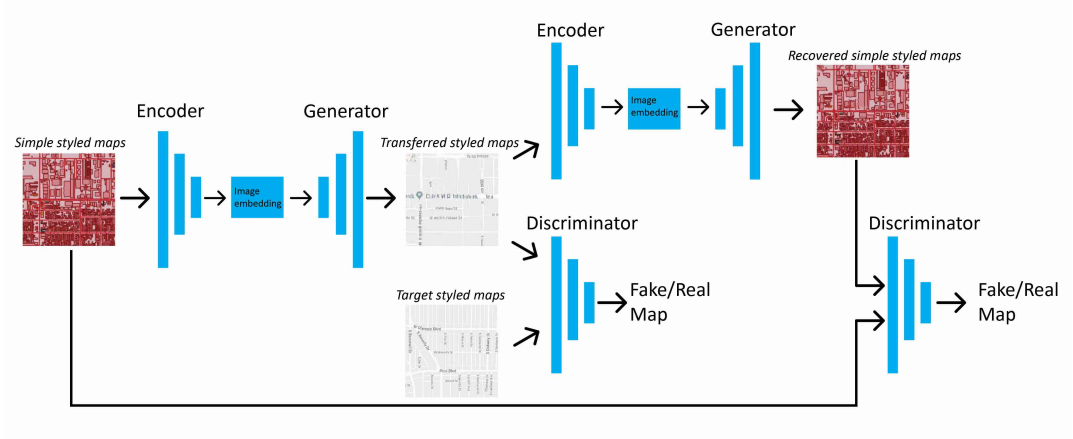

---

## **Implementação CycleGAN**

### Importações

In [1]:
import torch
import torch.nn as nn
import albumentations as A
from albumentations.pytorch import ToTensorV2
import sys
from torch.utils.data import DataLoader
import torch.optim as optim
from tqdm import tqdm
from torchvision.utils import save_image
from PIL import Image
import os
from torch.utils.data import Dataset
import numpy as np

In [2]:
class ConvolutionalBlock(nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        is_downsampling: bool = True,
        add_activation: bool = True,
        **kwargs
    ):
        super().__init__()
        if is_downsampling:
            self.conv = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, padding_mode="reflect", **kwargs),
                nn.InstanceNorm2d(out_channels),
                nn.ReLU(inplace=True) if add_activation else nn.Identity(),
            )
        else:
            self.conv = nn.Sequential(
                nn.ConvTranspose2d(in_channels, out_channels, **kwargs),
                nn.InstanceNorm2d(out_channels),
                nn.ReLU(inplace=True) if add_activation else nn.Identity(),
            )

    def forward(self, x):
        return self.conv(x)

In [3]:
class ResidualBlock(nn.Module):
    def __init__(self, channels: int):
        """
        In a residual block, the use of two ConvBlock instances with one having 
        an activation function and the other not is a design choice that promotes 
        the learning of residual information.

        The purpose of a residual block is to learn the residual mapping between
        the input and output of the block. The first ConvBlock in the sequence, 
        which includes an activation function, helps in capturing and extracting 
        important features from the input. The activation function introduces 
        non-linearity, allowing the network to model complex relationships 
        between the input and output.

        The second ConvBlock does not include an activation function. 
        It mainly focuses on adjusting the dimensions (e.g., number of channels) 
        of the features extracted by the first ConvBlock. The absence of an 
        activation function in the second ConvBlock allows the block to learn 
        the residual information. By directly adding the output of the second 
        ConvBlock to the original input, the block learns to capture the 
        residual features or changes needed to reach the desired output.

        (Information and explanation above generated by ChatGPT)
        """
        super().__init__()
        self.block = nn.Sequential(
            ConvolutionalBlock(channels, channels, add_activation=True, kernel_size=3, padding=1),
            ConvolutionalBlock(channels, channels, add_activation=False, kernel_size=3, padding=1),
        )

    def forward(self, x):
        """
        This skip connection, achieved through the addition operation, helps 
        in propagating gradients during training and alleviates the vanishing 
        gradient problem. It also facilitates the flow of information from earlier 
        layers to later layers, allowing the network to learn more effectively.

        (Information and explanation above generated by ChatGPT)
        """
        return x + self.block(x)

In [4]:
class Generator(nn.Module):
    def __init__(
        self, img_channels: int, num_features: int = 64, num_residuals: int = 9
    ):
        """
        Generator consists of 2 layers of downsampling/encoding layer, 
        followed by 9 residual blocks for 128 × 128 training images 
        and then 3 upsampling/decoding layer. 
        
        The network with 6 residual blocks can be written as: 
        c7s1–64, d128, d256, R256, R256, R256, R256, R256, R256, u128, u64, and c7s1–3.

        The network with 9 residual blocks consists of: 
        c7s1–64, d128, d256, R256, R256, R256, R256, R256, R256, R256, R256, R256, u128, u64, and c7s1–3.
        """
        super().__init__()
        self.initial_layer = nn.Sequential(
            nn.Conv2d(
                img_channels,
                num_features,
                kernel_size=7,
                stride=1,
                padding=3,
                padding_mode="reflect",
            ),
            nn.ReLU(inplace=True),
        )

        self.downsampling_layers = nn.ModuleList(
            [
                ConvolutionalBlock(
                    num_features, 
                    num_features * 2,
                    is_downsampling=True, 
                    kernel_size=3, 
                    stride=2, 
                    padding=1,
                ),
                ConvolutionalBlock(
                    num_features * 2,
                    num_features * 4,
                    is_downsampling=True,
                    kernel_size=3,
                    stride=2,
                    padding=1,
                ),
            ]
        )

        self.residual_layers = nn.Sequential(
            *[ResidualBlock(num_features * 4) for _ in range(num_residuals)]
        )

        self.upsampling_layers = nn.ModuleList(
            [
                ConvolutionalBlock(
                    num_features * 4,
                    num_features * 2,
                    is_downsampling=False,
                    kernel_size=3,
                    stride=2,
                    padding=1,
                    output_padding=1,
                ),
                ConvolutionalBlock(
                    num_features * 2,
                    num_features * 1,
                    is_downsampling=False,
                    kernel_size=3,
                    stride=2,
                    padding=1,
                    output_padding=1,
                ),
            ]
        )

        self.last_layer = nn.Conv2d(
            num_features * 1,
            img_channels,
            kernel_size=7,
            stride=1,
            padding=3,
            padding_mode="reflect",
        )

    def forward(self, x):
        x = self.initial_layer(x)
        for layer in self.downsampling_layers:
            x = layer(x)
        x = self.residual_layers(x)
        for layer in self.upsampling_layers:
            x = layer(x)
        return torch.tanh(self.last_layer(x))


In [5]:
class ConvInstanceNormLeakyReLUBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, stride: int):
        """
        Class object initialization for Convolution-InstanceNorm-LeakyReLU layer

        We use leaky ReLUs with a slope of 0.2.
        """
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size=4,
                stride=stride,
                padding=1,
                bias=True,
                padding_mode="reflect",
            ),
            nn.InstanceNorm2d(out_channels),
            nn.LeakyReLU(0.2, inplace=True),
        )

    def forward(self, x):
        return self.conv(x)


In [6]:
class Discriminator(nn.Module):
    def __init__(self, in_channels=3, features=[64, 128, 256, 512]):
        """
        Let Ck denote a 4 × 4 Convolution-InstanceNorm-LeakyReLU layer with 
        k filters and stride 2. Discriminator architecture is: C64-C128-C256-C512. 
        
        After the last layer, we apply a convolution to produce a 1-dimensional 
        output. 
        
        We use leaky ReLUs with a slope of 0.2.
        """
        super().__init__()
        self.initial_layer = nn.Sequential(
            nn.Conv2d(
                in_channels,
                features[0],
                kernel_size=4,
                stride=2,
                padding=1,
                padding_mode="reflect",
            ),
            nn.LeakyReLU(0.2, inplace=True),
        )

        layers = []
        in_channels = features[0]
        for feature in features[1:]:
            layers.append(
                ConvInstanceNormLeakyReLUBlock(
                    in_channels, 
                    feature, 
                    stride=1 if feature == features[-1] else 2,
                )
            )
            in_channels = feature

        # After the last layer, we apply a convolution to produce a 1-dimensional output 
        layers.append(
            nn.Conv2d(
                in_channels,
                1,
                kernel_size=4,
                stride=1,
                padding=1,
                padding_mode="reflect",
            )
        )
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = self.initial_layer(x)

        # feed the model output into a sigmoid function to make a 1/0 label
        return torch.sigmoid(self.model(x))

In [7]:
import os
import cv2
import numpy as np
from PIL import Image
from torch.utils.data import Dataset

class EmojiPeople(Dataset):
    def __init__(self, root_emoji, root_people, transform=None, img_size=256):
        self.root_emoji = root_emoji
        self.root_people = root_people
        self.emojis_images = os.listdir(root_emoji)
        self.people_images = os.listdir(root_people)
        self.transform = transform
        self.img_size = img_size

    def __len__(self):
        return min(len(self.emojis_images), len(self.people_images))

    def __getitem__(self, index):
        emoji_path = os.path.join(self.root_emoji, self.emojis_images[index])
        people_path = os.path.join(self.root_people, self.people_images[index])

        # Abrir imagens
        emoji_img = np.array(Image.open(emoji_path).convert("RGB"))
        people_img = np.array(Image.open(people_path).convert("RGB"))

        # ✅ Redimensionar antes de aplicar as transforms
        emoji_img = cv2.resize(emoji_img, (self.img_size, self.img_size))
        people_img = cv2.resize(people_img, (self.img_size, self.img_size))

        if self.transform:
            augmentations = self.transform(image=emoji_img, image0=people_img)
            emoji_img = augmentations["image"]
            people_img = augmentations["image0"]

        return emoji_img, people_img


In [8]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"using device: {DEVICE}")

TRAIN_DIR = "data/train"
VAL_DIR = "data/val"
BATCH_SIZE = 200
LEARNING_RATE = 2e-4
LAMBDA_IDENTITY = 0.0 # loss weight for identity loss
LAMBDA_CYCLE = 10
NUM_WORKERS = 4
NUM_EPOCHS = 20
LOAD_MODEL = True
SAVE_MODEL = True
CHECKPOINT_GENERATOR_P = "models/genh.pth.tar"
CHECKPOINT_GENERATOR_E = "models/genz.pth.tar"
CHECKPOINT_DISCRIMINATOR_P = "models/disch.pth.tar"
CHECKPOINT_DISCRIMINATOR_E = "models/discz.pth.tar"

transforms = A.Compose(
    [
        A.Resize(width=256, height=256),
        A.HorizontalFlip(p=0.5),
        A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], max_pixel_value=255),
        ToTensorV2(),
    ],
    additional_targets={"image0": "image"},
)

using device: cpu


In [9]:
import random, torch, os, numpy as np
import torch.nn as nn
import copy

def save_checkpoint(model, optimizer, filename="models/checkpoint.pth.tar"):
    os.makedirs(os.path.dirname(filename), exist_ok=True)
    print(f"=> Saving checkpoint to {filename}")
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    torch.save(checkpoint, filename)


def load_checkpoint(checkpoint_file, model, optimizer, lr):
    if not os.path.isfile(checkpoint_file):
        print(f"=> Checkpoint not found: {checkpoint_file}. Skipping load.")
        return False
    try:
        print(f"=> Loading checkpoint: {checkpoint_file}")
        checkpoint = torch.load(checkpoint_file, map_location=DEVICE)
        model.load_state_dict(checkpoint["state_dict"])
        optimizer.load_state_dict(checkpoint["optimizer"])
        for param_group in optimizer.param_groups:
            param_group["lr"] = lr
        return True
    except Exception as e:
        print(f"=> Error loading checkpoint {checkpoint_file}: {e}")
        return False

# create output and models dirs at script start (safe to call multiple times)
os.makedirs("models", exist_ok=True)
os.makedirs("outputs", exist_ok=True)


def seed_everything(seed=42):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [10]:
from torchvision.utils import save_image
import os

def train_fn(
    disc_P, disc_E, gen_E, gen_P, loader,
    opt_disc, opt_gen, L1, mse,
    d_scaler, g_scaler, epoch=0
):
    P_reals = 0
    P_fakes = 0
    loop = tqdm(loader, leave=True)

    os.makedirs("samples", exist_ok=True)
    os.makedirs("models", exist_ok=True)

    for idx, (emoji, people) in enumerate(loop):
        emoji = emoji.to(DEVICE)
        people = people.to(DEVICE)

        with torch.cuda.amp.autocast():
            fake_people = gen_P(emoji)
            D_P_real = disc_P(people)
            D_P_fake = disc_P(fake_people.detach())
            D_P_real_loss = mse(D_P_real, torch.ones_like(D_P_real))
            D_P_fake_loss = mse(D_P_fake, torch.zeros_like(D_P_fake))
            D_P_loss = (D_P_real_loss + D_P_fake_loss) / 2

            fake_emoji = gen_E(people)
            D_E_real = disc_E(emoji)
            D_E_fake = disc_E(fake_emoji.detach())
            D_E_real_loss = mse(D_E_real, torch.ones_like(D_E_real))
            D_E_fake_loss = mse(D_E_fake, torch.zeros_like(D_E_fake))
            D_E_loss = (D_E_real_loss + D_E_fake_loss) / 2

            D_loss = (D_P_loss + D_E_loss) / 2

        opt_disc.zero_grad()
        d_scaler.scale(D_loss).backward()
        d_scaler.step(opt_disc)
        d_scaler.update()

        with torch.cuda.amp.autocast():
            D_P_fake = disc_P(fake_people)
            D_E_fake = disc_E(fake_emoji)
            loss_G_P = mse(D_P_fake, torch.ones_like(D_P_fake))
            loss_G_E = mse(D_E_fake, torch.ones_like(D_E_fake))

            cycle_emoji = gen_E(fake_people)
            cycle_people = gen_P(fake_emoji)
            cycle_emoji_loss = L1(emoji, cycle_emoji)
            cycle_people_loss = L1(people, cycle_people)

            identity_emoji = gen_E(emoji)
            identity_people = gen_P(people)
            identity_emoji_loss = L1(emoji, identity_emoji)
            identity_people_loss = L1(people, identity_people)

            G_loss = (
                loss_G_P
                + loss_G_E
                + cycle_emoji_loss * 10
                + cycle_people_loss * 10
                + identity_emoji_loss * 5
                + identity_people_loss * 5
            )

        opt_gen.zero_grad()
        g_scaler.scale(G_loss).backward()
        g_scaler.step(opt_gen)
        g_scaler.update()

        if idx % 100 == 0:
            loop.set_postfix(
                D_loss=D_loss.item(),
                G_loss=G_loss.item()
            )

        # ✅ SAVE CHECKPOINTS a cada 500 iters
        if idx % 500 == 0 and idx > 0:
            print(f"\n💾 Saving checkpoints at iteration {idx}")
            save_checkpoint(gen_P, opt_gen, filename="models/genP_iter.pth.tar")
            save_checkpoint(gen_E, opt_gen, filename="models/genE_iter.pth.tar")
            save_checkpoint(disc_P, opt_disc, filename="models/discP_iter.pth.tar")
            save_checkpoint(disc_E, opt_disc, filename="models/discE_iter.pth.tar")

        # ✅ GERAR AMOSTRAS VISUAIS a cada 500 iters
        if idx % 500 == 0 and idx > 0:
            gen_P.eval()
            gen_E.eval()
            with torch.no_grad():
                fake_people_sample = gen_P(emoji[:1])
                fake_emoji_sample = gen_E(people[:1])
                save_image(fake_people_sample * 0.5 + 0.5,
                           f"samples/fake_people_iter_{epoch}_{idx}.png")
                save_image(fake_emoji_sample * 0.5 + 0.5,
                           f"samples/fake_emoji_iter_{epoch}_{idx}.png")
            gen_P.train()
            gen_E.train()


In [ ]:
def main():
    disc_P = Discriminator(in_channels=3).to(DEVICE)
    disc_E = Discriminator(in_channels=3).to(DEVICE)
    gen_E = Generator(img_channels=3, num_residuals=9).to(DEVICE)
    gen_P = Generator(img_channels=3, num_residuals=9).to(DEVICE)

    # use Adam Optimizer for both generator and discriminator
    opt_disc = optim.Adam(
        list(disc_P.parameters()) + list(disc_E.parameters()),
        lr=LEARNING_RATE,
        betas=(0.5, 0.999),
    )

    opt_gen = optim.Adam(
        list(gen_E.parameters()) + list(gen_P.parameters()),
        lr=LEARNING_RATE,
        betas=(0.5, 0.999),
    )

    L1 = nn.L1Loss()
    mse = nn.MSELoss()

    if LOAD_MODEL:
        # load_checkpoint already checks file existence and returns False if not present
        load_checkpoint(CHECKPOINT_GENERATOR_P, gen_P, opt_gen, LEARNING_RATE)
        load_checkpoint(CHECKPOINT_GENERATOR_E, gen_E, opt_gen, LEARNING_RATE)
        load_checkpoint(CHECKPOINT_DISCRIMINATOR_P, disc_P, opt_disc, LEARNING_RATE)
        load_checkpoint(CHECKPOINT_DISCRIMINATOR_E, disc_E, opt_disc, LEARNING_RATE)


    dataset = EmojiPeople(
        root_people=TRAIN_DIR + "/people",
        root_emoji=TRAIN_DIR + "/emoji",
        transform=transforms,
    )
    val_dataset = EmojiPeople(
        root_people=VAL_DIR + "/people",
        root_emoji=VAL_DIR + "/emoji",
        transform=transforms,
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        pin_memory=True,
    )
    loader = DataLoader(
        dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=NUM_WORKERS,
        pin_memory=True,
    )
    g_scaler = torch.cuda.amp.GradScaler()
    d_scaler = torch.cuda.amp.GradScaler()

    for epoch in range(NUM_EPOCHS):
        train_fn(
            disc_P,
            disc_E,
            gen_E,
            gen_P,
            loader,
            opt_disc,
            opt_gen,
            L1,
            mse,
            d_scaler,
            g_scaler,
        )

        if SAVE_MODEL:
            save_checkpoint(gen_P, opt_gen, filename=CHECKPOINT_GENERATOR_P)
            save_checkpoint(gen_E, opt_gen, filename=CHECKPOINT_GENERATOR_E)
            save_checkpoint(disc_P, opt_disc, filename=CHECKPOINT_DISCRIMINATOR_P)
            save_checkpoint(disc_E, opt_disc, filename=CHECKPOINT_DISCRIMINATOR_E)


main()

/tmp/ipykernel_33034/769038335.py:54: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  g_scaler = torch.cuda.amp.GradScaler()
/home/cristina/Documentos/GANS_Não_Sup/.venv/lib/python3.12/site-packages/torch/cuda/amp/grad_scaler.py:31: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  super().__init__(
/tmp/ipykernel_33034/769038335.py:55: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  d_scaler = torch.cuda.amp.GradScaler()


=> Checkpoint not found: models/genh.pth.tar. Skipping load.
=> Checkpoint not found: models/genz.pth.tar. Skipping load.
=> Checkpoint not found: models/disch.pth.tar. Skipping load.
=> Checkpoint not found: models/discz.pth.tar. Skipping load.


  0%|          | 0/500 [00:00<?, ?it/s]/home/cristina/Documentos/GANS_Não_Sup/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/tmp/ipykernel_33034/3091476628.py:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/cristina/Documentos/GANS_Não_Sup/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
